In [1]:
from typing import List
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from chinese_checkers.reinforcement.experience import ExperienceData, ExperienceCatalog, ExperienceMetadata
from chinese_checkers.reinforcement.dql import DQLAgent, DqlModelValidation
import torch
import logging
from src.chinese_checkers.simulation.GameSimulation import GameSimulation
from src.chinese_checkers.model.BootstrapModel import BootstrapModel
from src.chinese_checkers.reinforcement.dql.DqlModel import DqlModel

# DQL Module Examples

---

## Example 1: Train the model on encoded experience data


### 1. Load the simulation datasets from the Simulation catalog

In [2]:
catalog = ExperienceCatalog()
dataset_metadata: List[ExperienceMetadata] = catalog.list_datasets()
dataset_metadata

[ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='0'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='3'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='3', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='0'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='3', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='3'),
 ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bad-player-3-bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='0'),
 ExperienceMetadata(player_count

In [3]:
winning_players = ["0","3"] 
player_count = 2
current_player = "0"

experiences: List[ExperienceData] = [
    dataset
    for metadata in dataset_metadata
    if metadata.winning_player in winning_players
        and metadata.player_count == str(player_count)
        and metadata.current_player == current_player
    for dataset in catalog.load_dataset(metadata)
]
print(f"Found {len(experiences)} datasets for winning_players: {winning_players}, player_count: {player_count}, and current_player: {current_player}.")

Found 171697 datasets for winning_players: ['0', '3'], player_count: 2, and current_player: 0.


In [4]:
p0_win_count = len([e for e in experiences if e.metadata.winning_player =="0"])
p3_win_count = len([e for e in experiences if e.metadata.winning_player =="3"])

print(f"p0_win_count {p0_win_count}, p3_win_count {p3_win_count}")

print(f"Sample Loss: {[e for e in experiences if e.metadata.winning_player =="0"][0]}")
print(f"Sample Win: {[e for e in experiences if e.metadata.winning_player =="3"][0]}")

p0_win_count 23265, p3_win_count 19577
Sample Loss: Experience(data=ExperienceData(state=tensor([ 0.0000,  0.3571,  0.5000,  0.5590,  0.0000, 10.0000]), action=tensor([0.2500, 1.9526, 1.7678]), reward=tensor([60.]), next_state=tensor([0.1031, 0.3580, 0.7071, 1.0607, 0.0000, 9.0000]), done=tensor([1.])), metadata=ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='0', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='0'))
Sample Win: Experience(data=ExperienceData(state=tensor([0.2358, 0.3734, 0.7071, 1.6771, 0.0000, 8.0000]), action=tensor([0.2500, 1.9526, 1.7678]), reward=tensor([4.2400]), next_state=tensor([ 0.0000,  0.4192,  1.0000,  0.5590,  0.0000, 10.0000]), done=tensor([1.])), metadata=ExperienceMetadata(player_count='2', board_size='4', max_game_length='1000', winning_player='3', name='bootstrap-simulation', version='v0.0.1', generator_name='v0.0.1', current_player='0'))


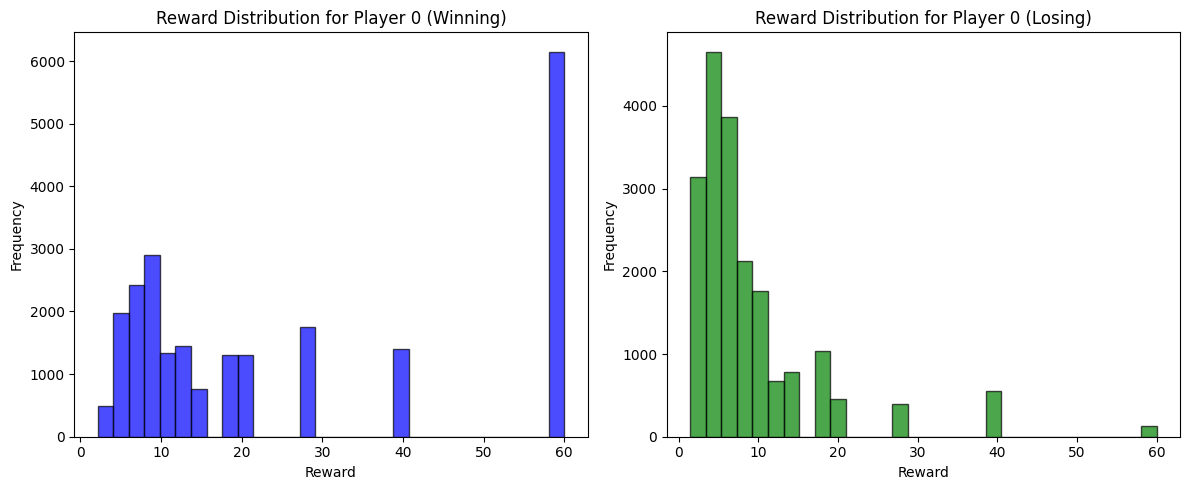

In [5]:
import matplotlib.pyplot as plt

# Extract rewards for each player group
p0_rewards = [e.data.reward.item() for e in experiences if e.metadata.winning_player == "0"]
p3_rewards = [e.data.reward.item() for e in experiences if e.metadata.winning_player == "3"]

# Plot reward distributions
plt.figure(figsize=(12, 5))

# Player 0 rewards distribution
plt.subplot(1, 2, 1)
plt.hist(p0_rewards, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Reward Distribution for Player 0 (Winning)")
plt.xlabel("Reward")
plt.ylabel("Frequency")

# Player 3 rewards distribution
plt.subplot(1, 2, 2)
plt.hist(p3_rewards, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title("Reward Distribution for Player 0 (Losing)")
plt.xlabel("Reward")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [7]:
from tqdm import tqdm
import torch
import random

# Shuffle and split the dataset into training and validation sets (80/20 split)
experience_datas = [e.data for e in experiences]
train_experiences, test_experiences = train_test_split(experience_datas, test_size=0.2, random_state=42)

# Define model parameters
state_dim = experience_datas[0].state.shape[0]
move_dim = experience_datas[0].action.shape[0]
gamma = 0.99
lr = 0.00001
batch_size = 256  # Configurable batch size
model_save_path = "dlq_agent_model_v002.pth"

In [9]:


# Initialize the DQL agent with specified dimensions
agent = DQLAgent(state_dim=state_dim, move_dim=move_dim, gamma=gamma, lr=lr, batch_size=batch_size)

# Training loop with validation at each epoch
print("Starting training...")
num_epochs = 25
with tqdm(range(num_epochs), desc="Training Progress") as epoch_bar:
    for epoch in epoch_bar:
        # Shuffle training data each epoch for better generalization
        random.shuffle(train_experiences)
        
        # Training phase
        for i in range(0, len(train_experiences), batch_size):
            batch_experiences = train_experiences[i:i + batch_size]
            for experience in batch_experiences:
                agent.store_experience(experience)  # Store each experience in the batch
            agent.train()  # Train on the batch

        # Validation phase
        validation = DqlModelValidation(agent.q_network, gamma=gamma, test_set=test_experiences, validation_set=train_experiences)
        results = validation.validate()
        
        # Update the progress bar with validation results
        epoch_bar.set_postfix({
            "Test Error": f"{results['test_error']:.4f}",
            "Validation Error": f"{results['validation_error']:.4f}"
        })

print("Training complete.")

# Save the trained model
torch.save(agent.q_network.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")
# it ticketd up to Training Progress:  48%|████▊     | 31/65 [05:42<06:15, 11.06s/it, Test Error=298.2045, Validation Error=296.9166]

Starting training...


Training Progress: 100%|██████████| 25/25 [05:22<00:00, 12.90s/it, Test Error=284.3235, Validation Error=280.6475]

Training complete.
Model saved to dlq_agent_model_v002.pth


C:\Users\dakot\Documents\Stanford\CS223\ChineseCheckersGameEngine\ChineseCheckersGameEngine\src\chinese_checkers\reinforcement\dql\DqlModel.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

Model loaded successfully from dlq_agent_model_v002.pth
Model loaded successfully from dlq_agent_model_v002.pth


Game did not finish within the maximum of 10000 turns.


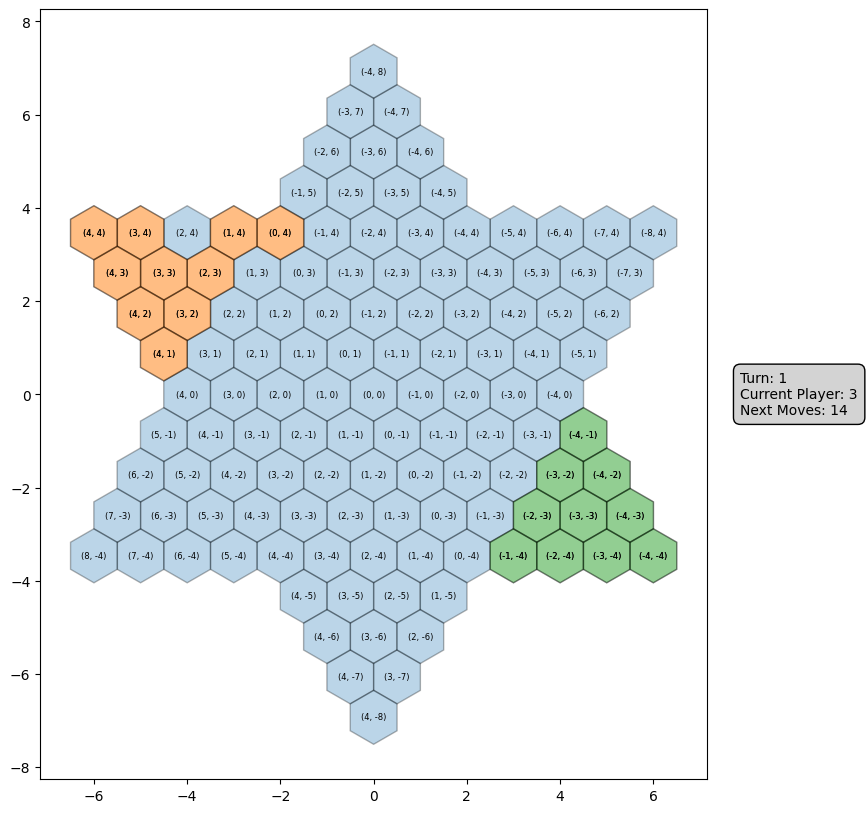

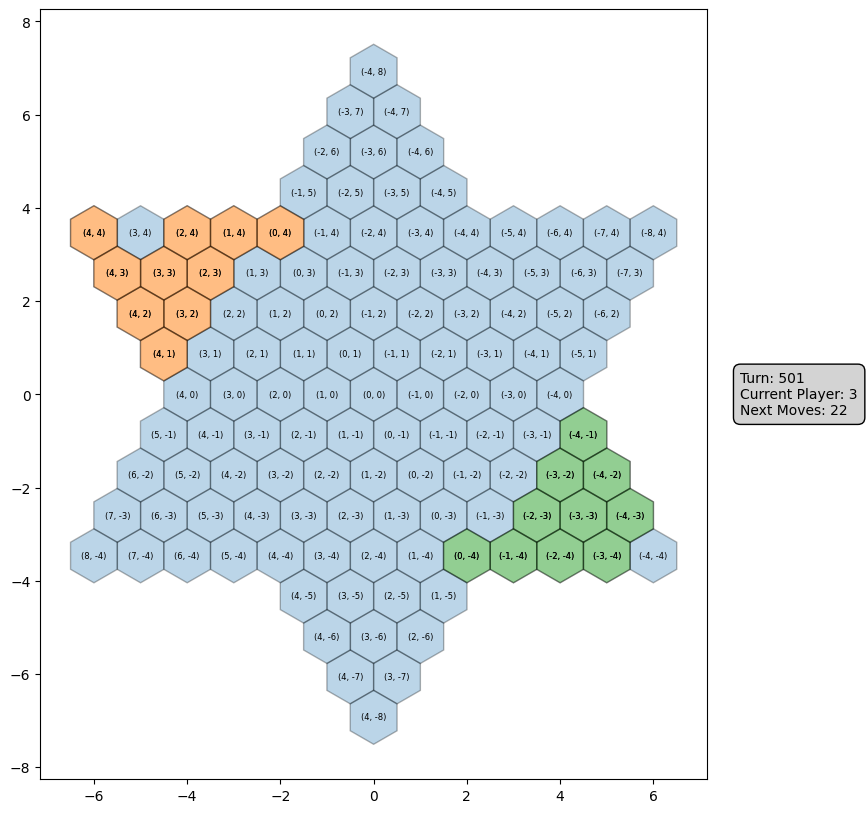

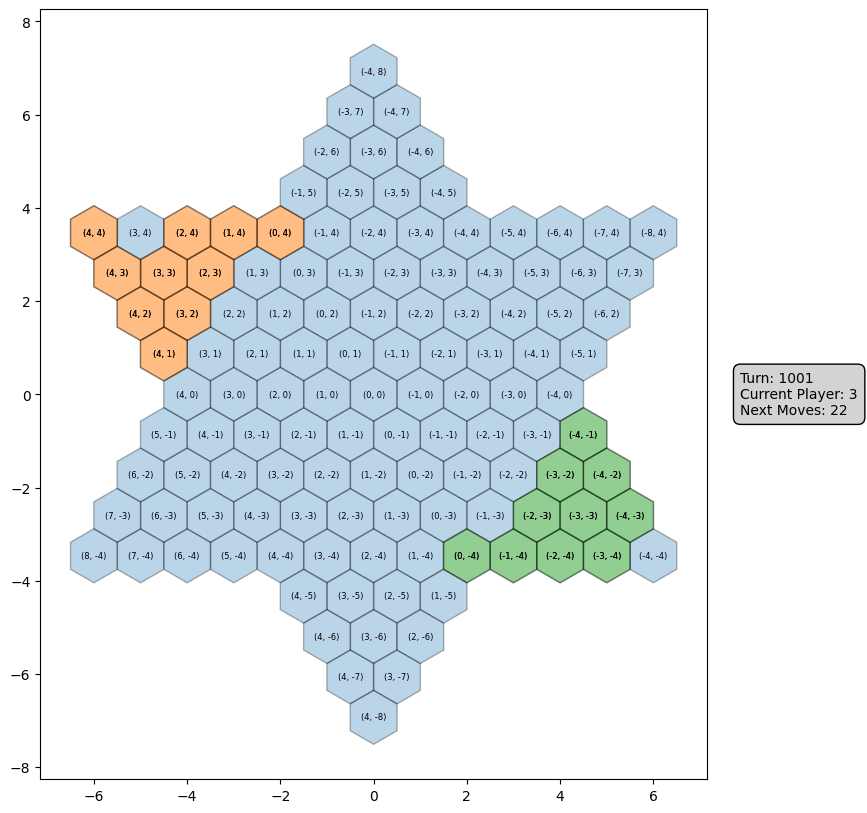

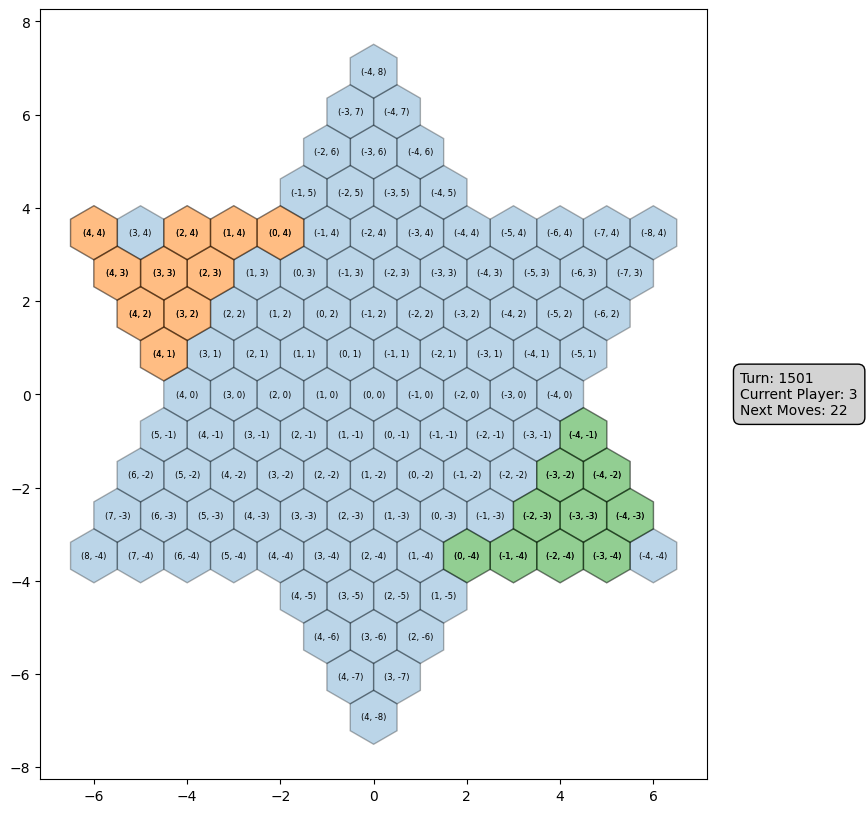

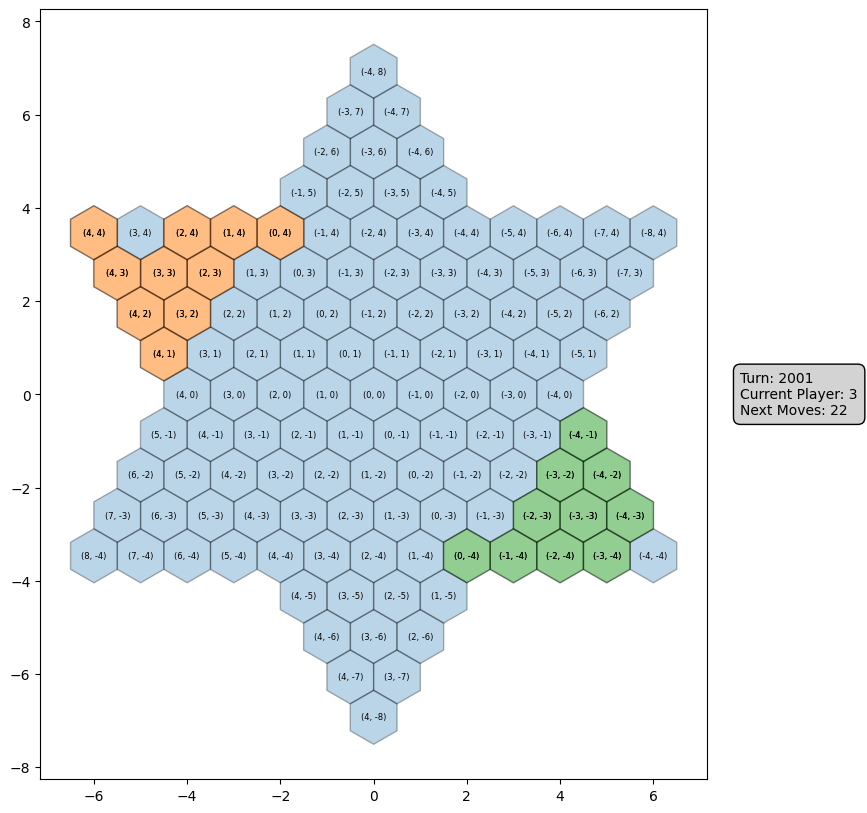

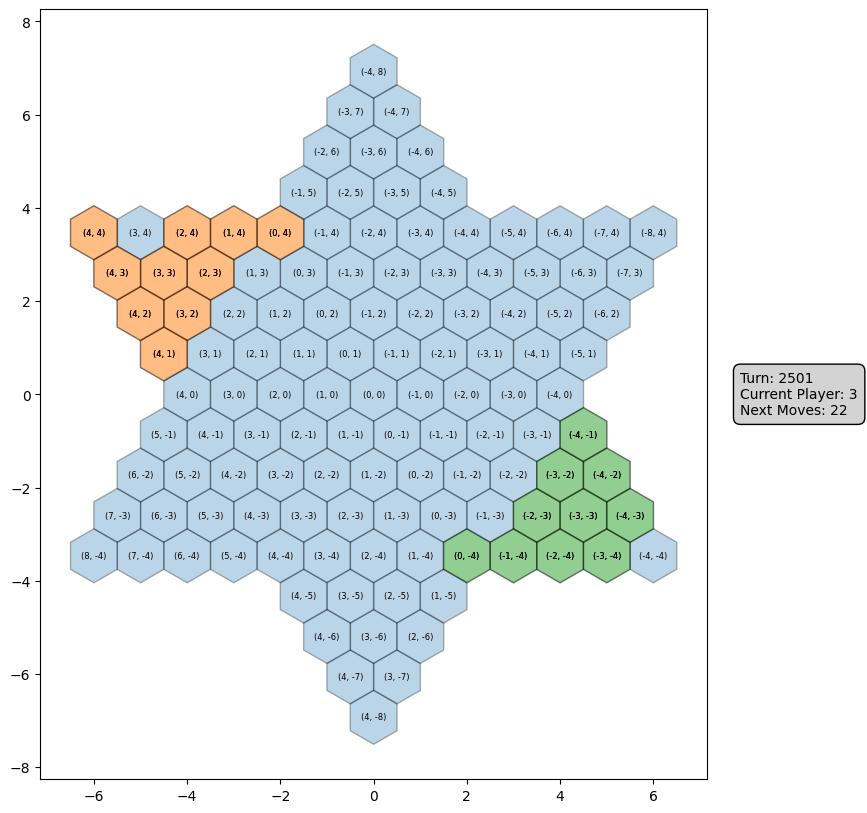

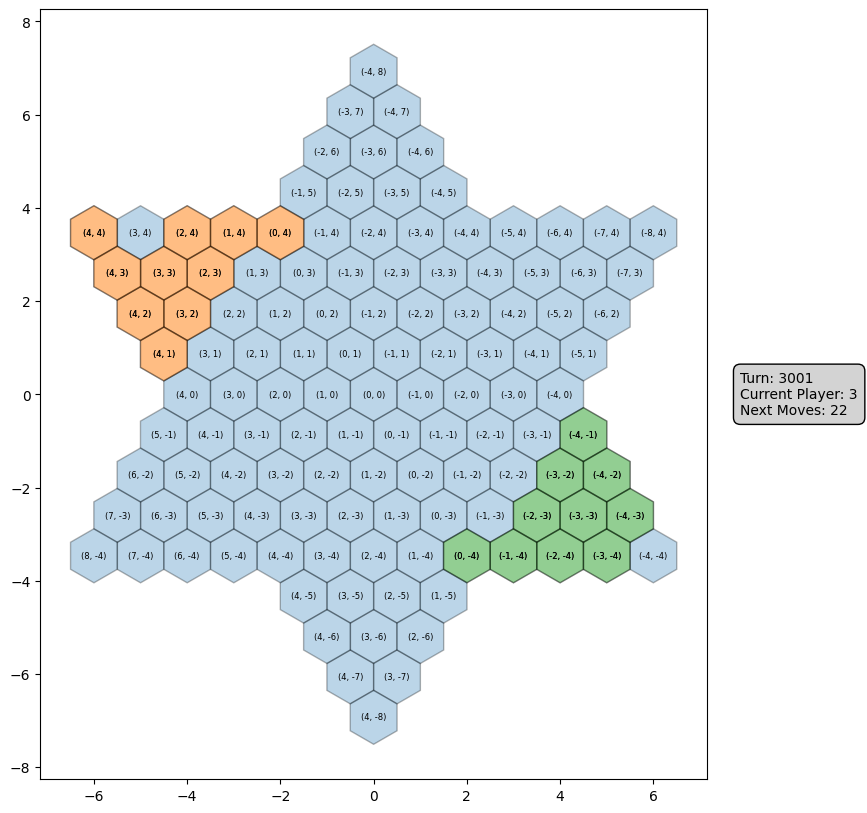

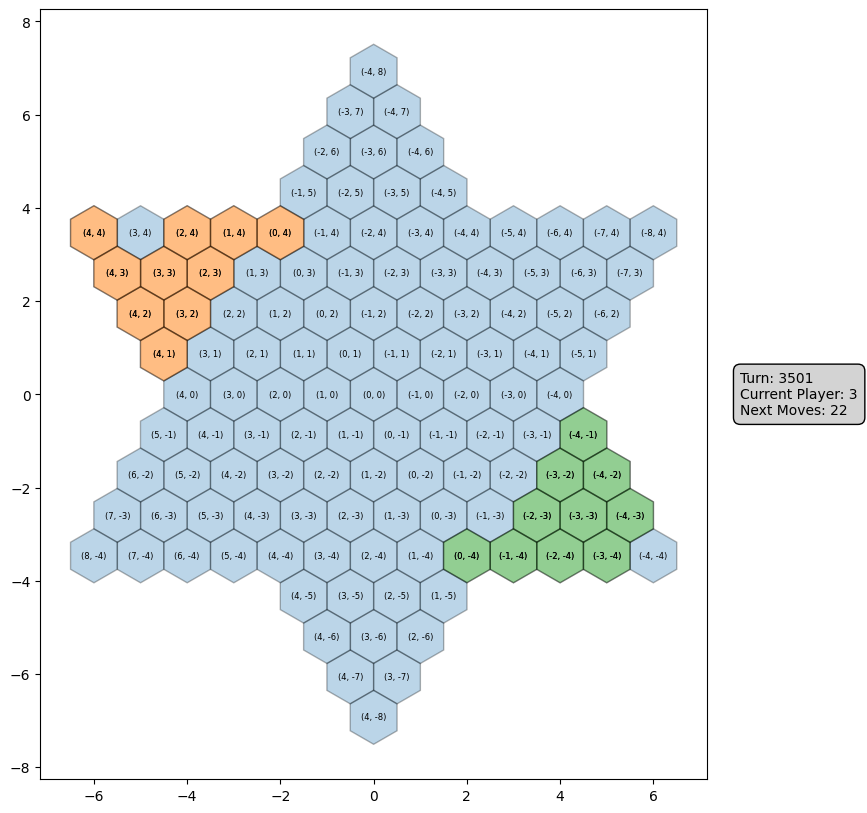

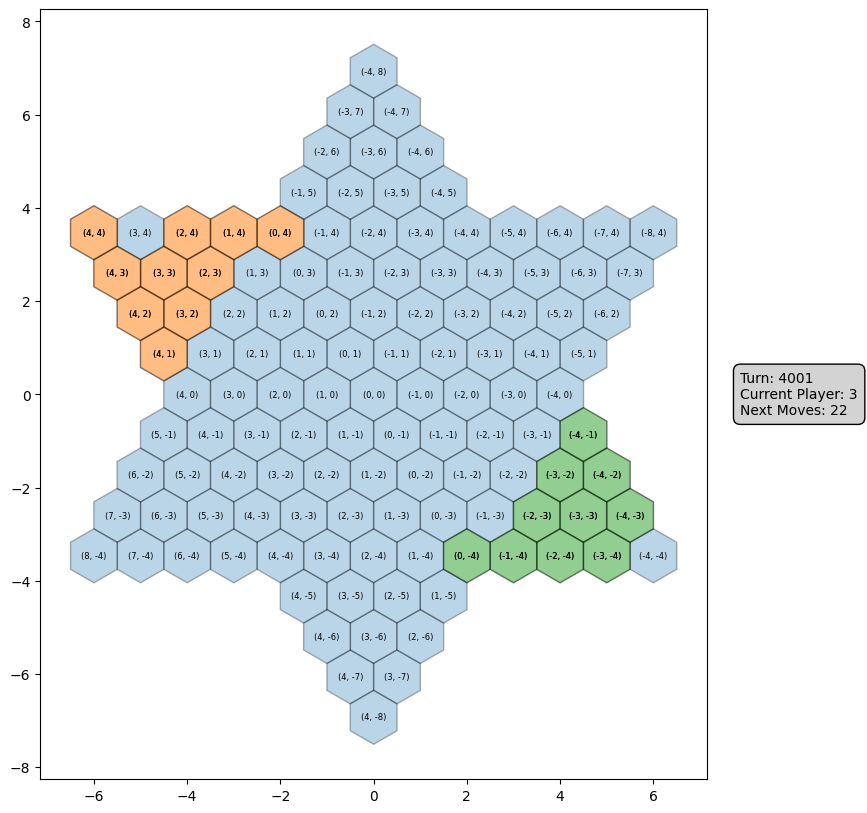

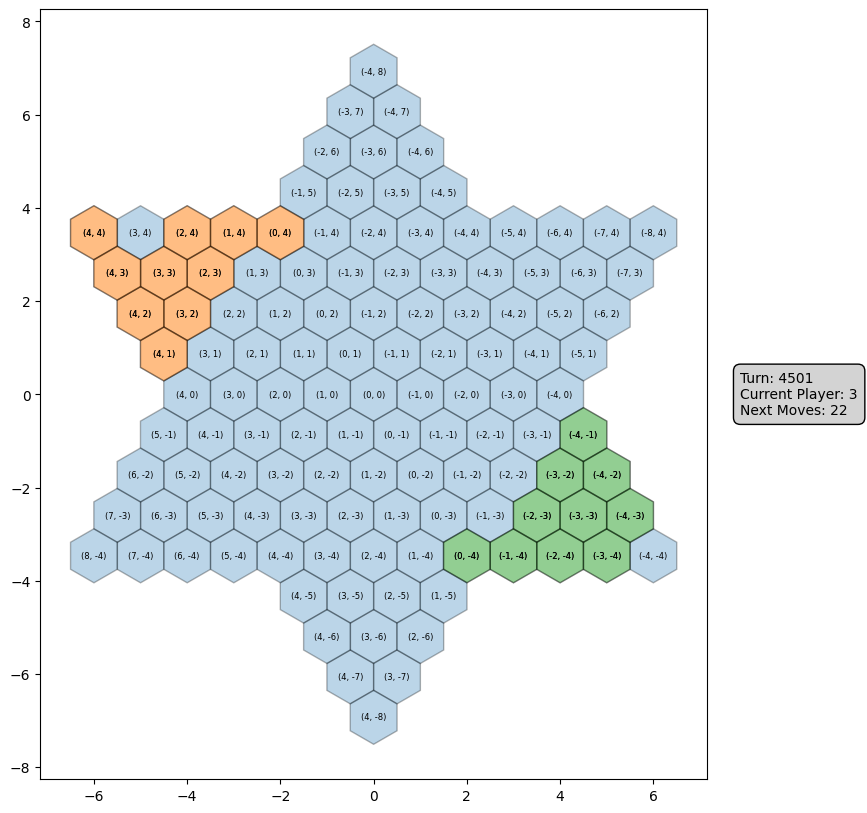

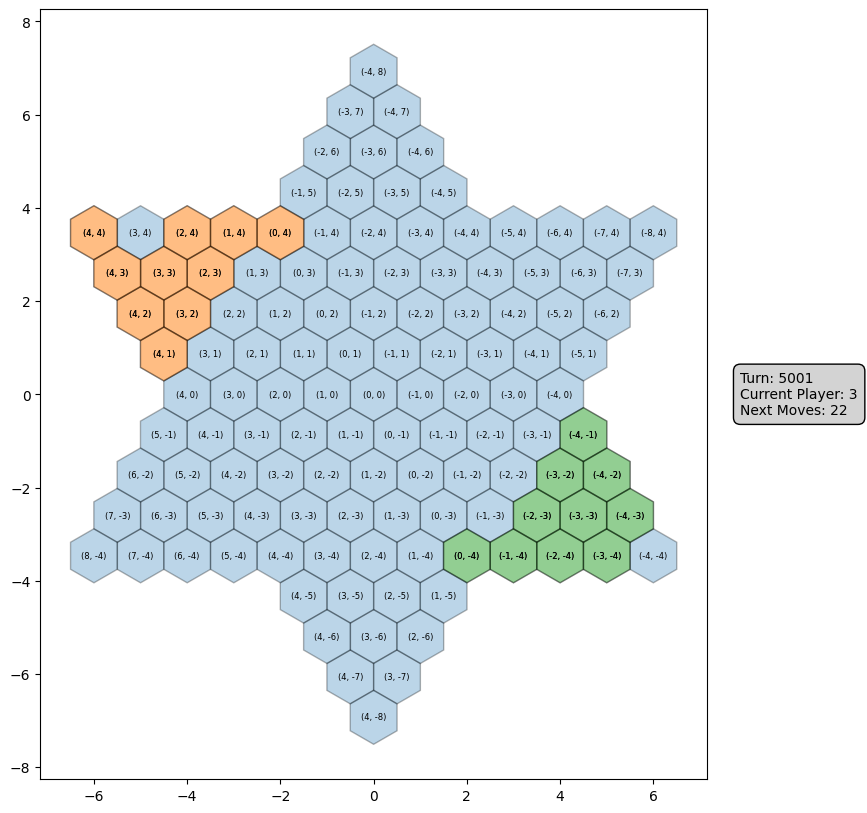

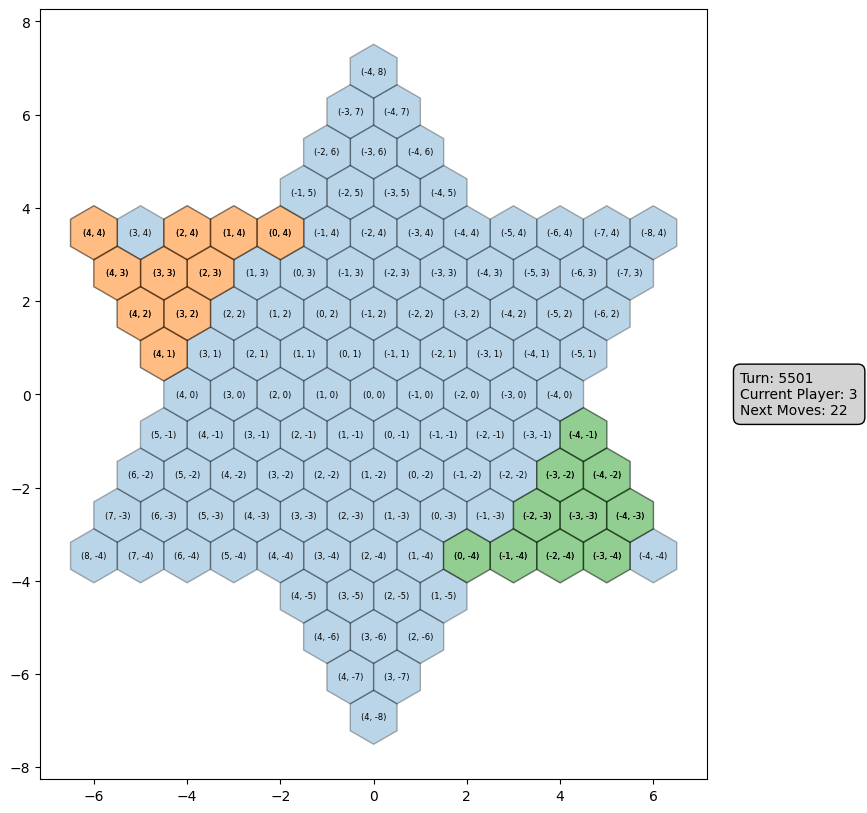

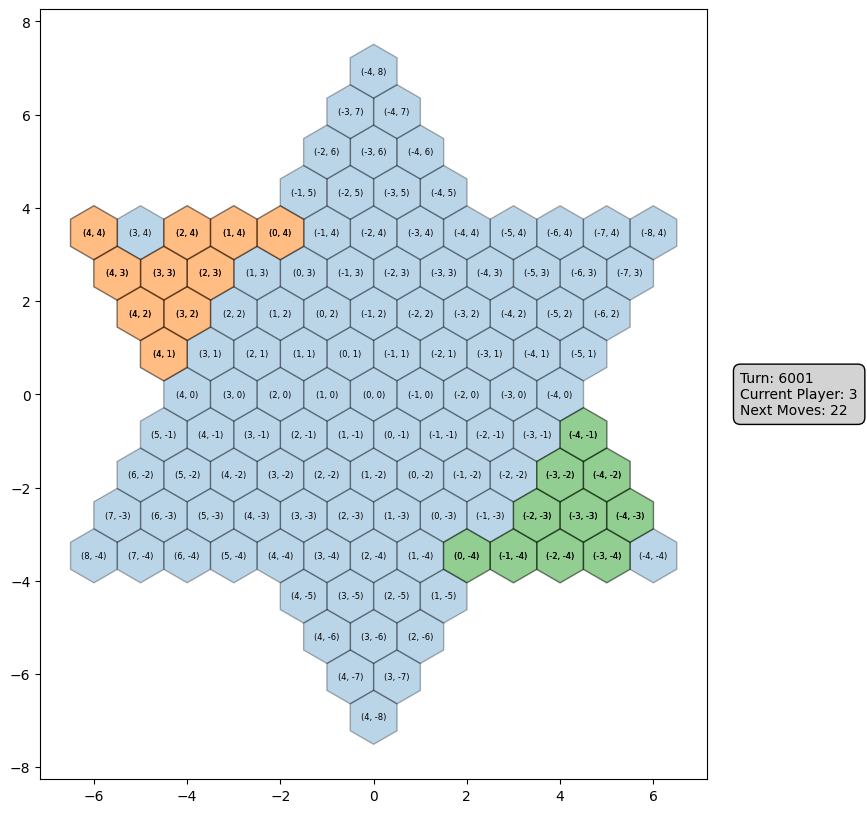

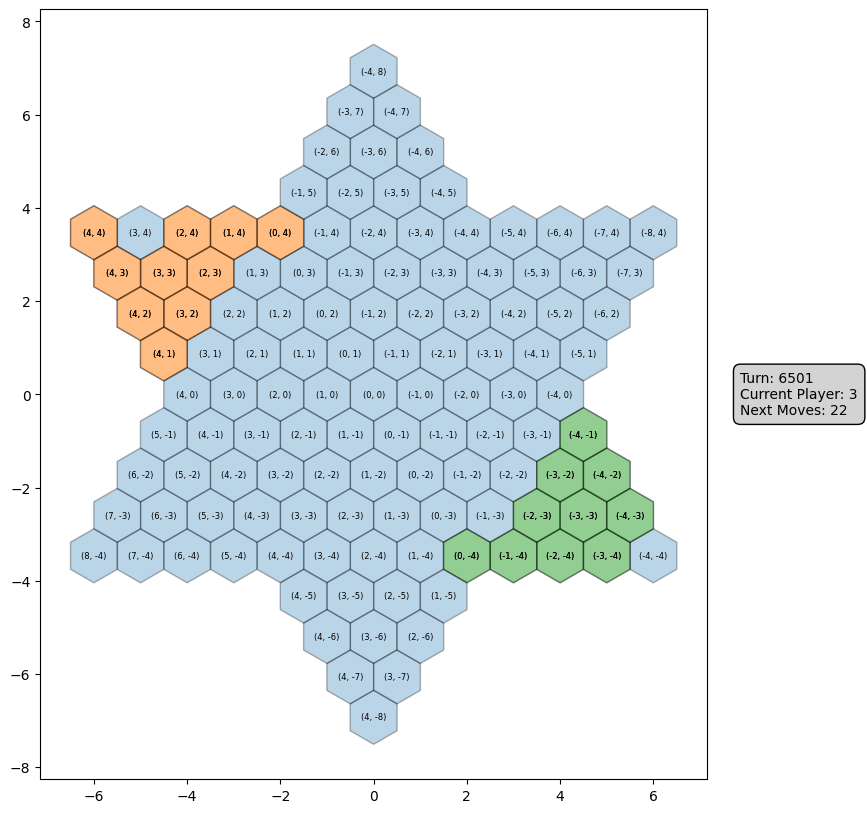

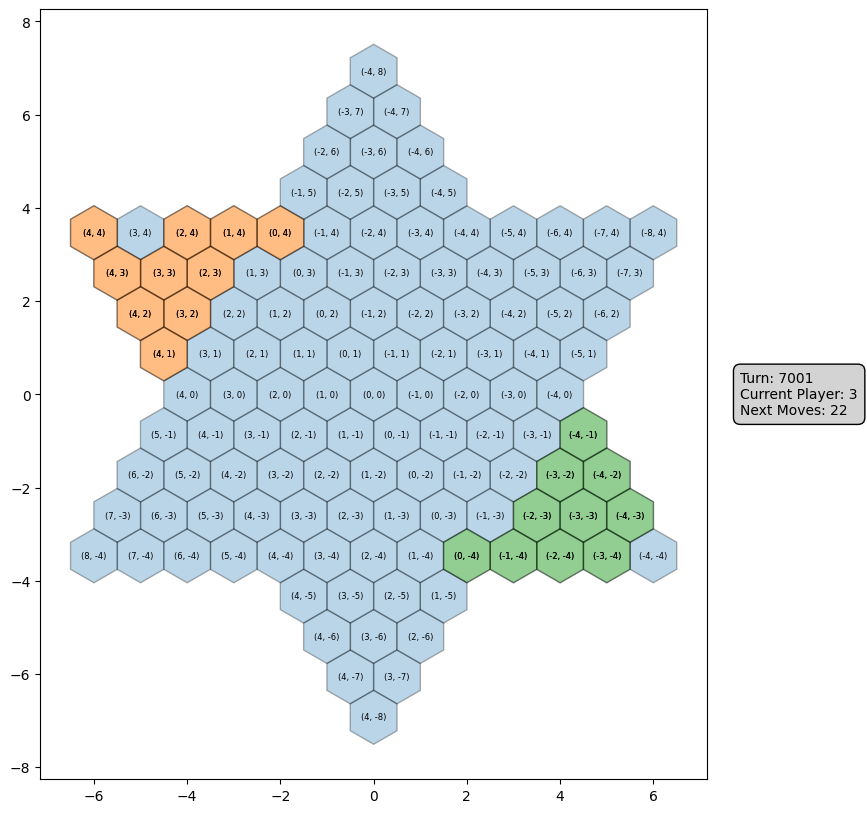

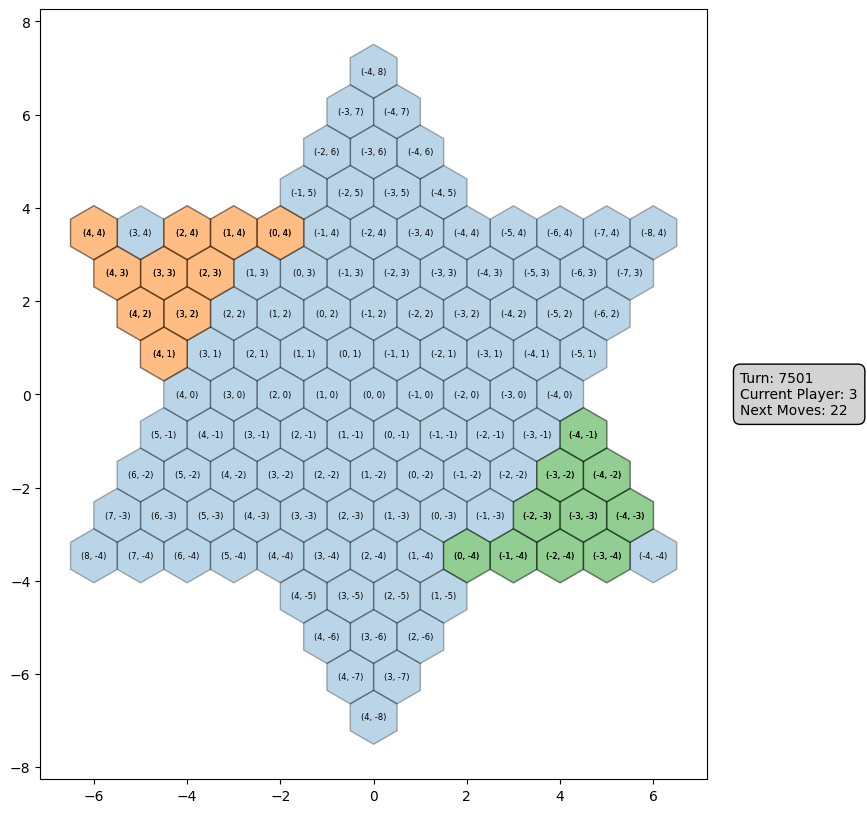

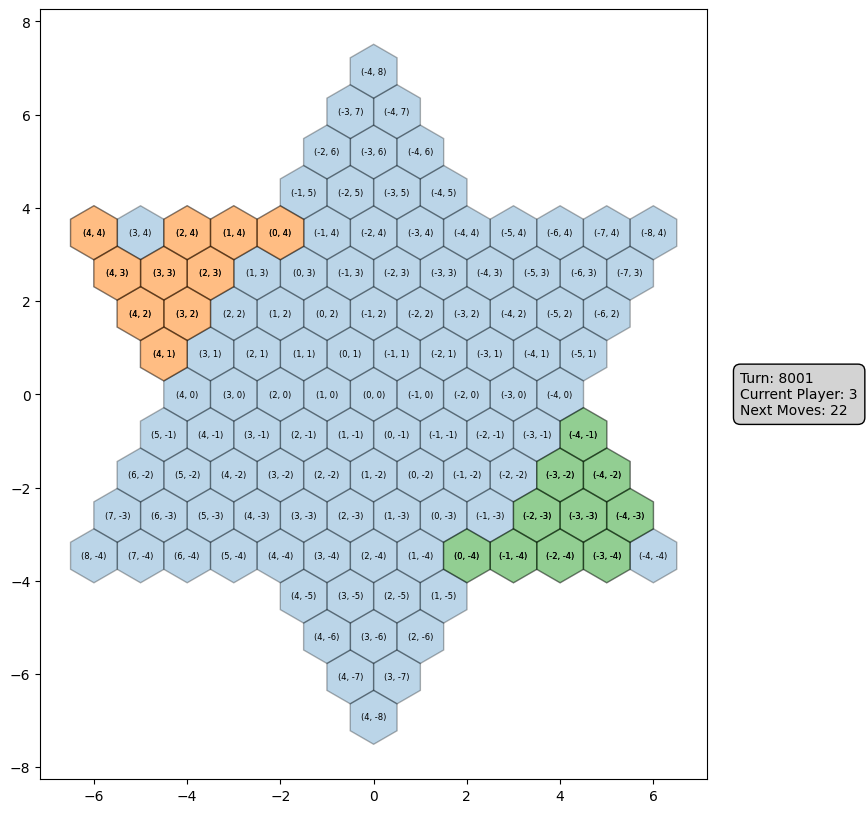

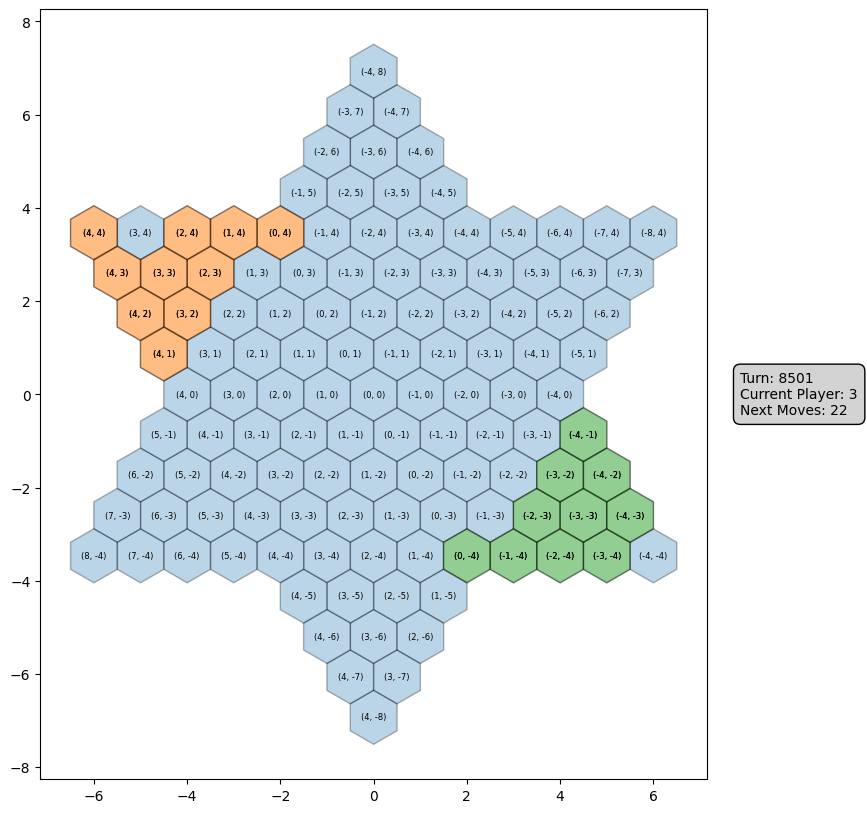

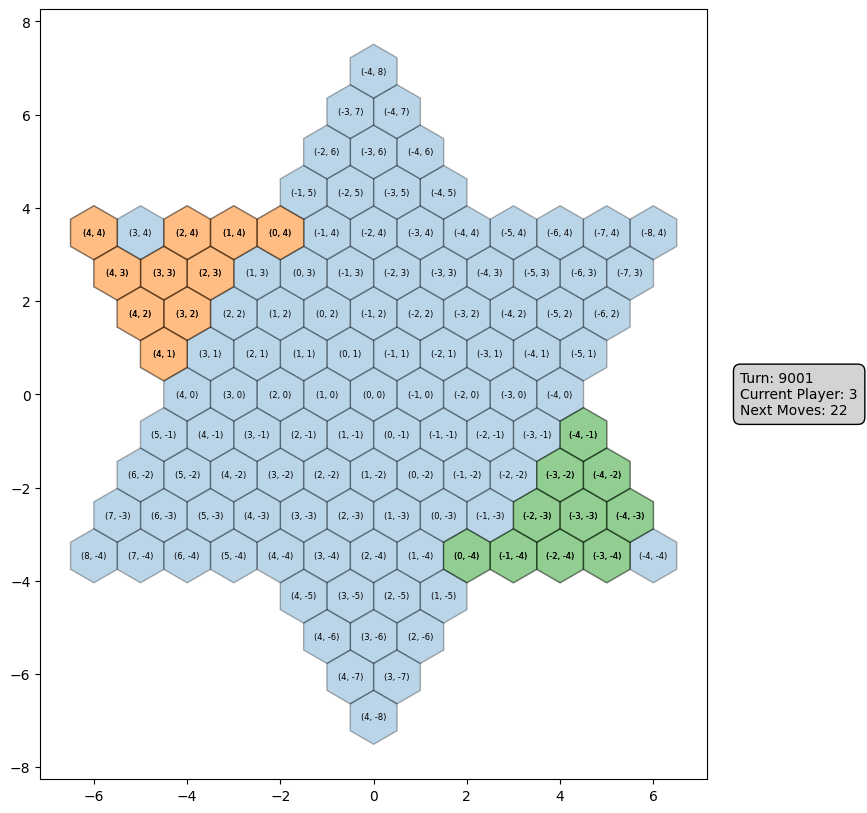

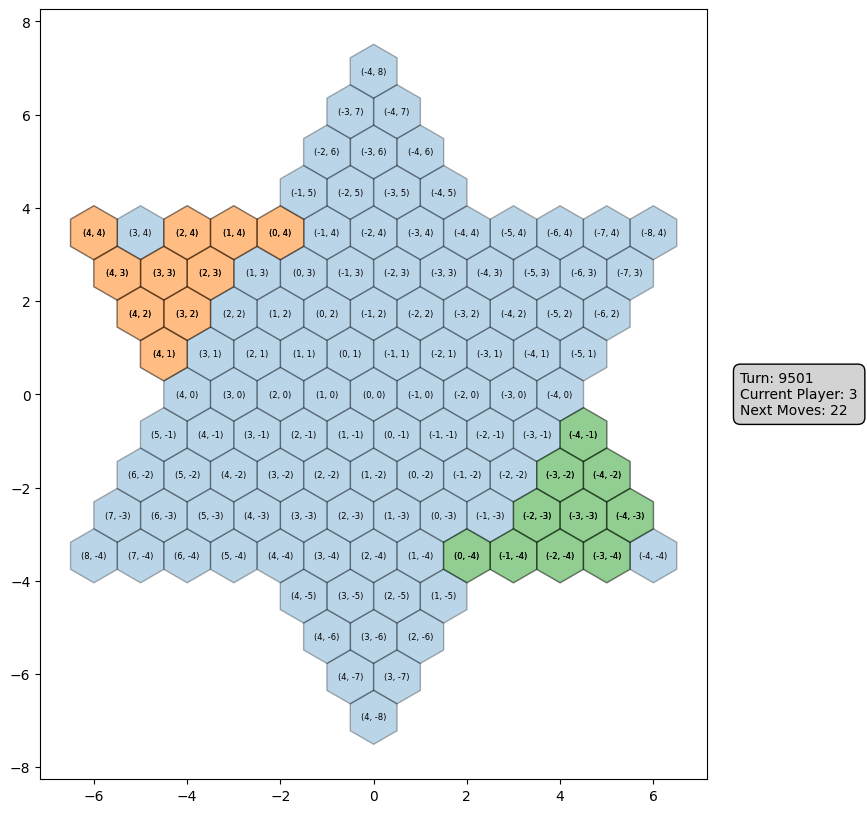

In [10]:


# # Enable logging if needed
# logging.basicConfig(level=logging.INFO)

# bootstrap_model = BootstrapModel()
dql_model = DqlModel(
    q_network_path="dlq_agent_model_v002.pth", 
    state_dim=state_dim,                                
    action_dim=move_dim,                              
    board_size=4                               
)

dql_model_2 = DqlModel(
    q_network_path="dlq_agent_model_v002.pth", 
    state_dim=state_dim,                                
    action_dim=move_dim,                              
    board_size=4                               
)

# Simulate the game using the models
game_simulation = GameSimulation.simulate_game(
    models=[dql_model, dql_model_2],  # DQL model plays against the bootstrap model
    name="dql_vs_bootstrap_simulation",
    version="v1.0.0",
    print_period=500,
    show_coordinates=True,
    max_turns=10000
)


In [11]:
game_simulation.save_animation()

Creating Animation:   0%|          | 0/1001 [00:00<?, ?it/s]



Current Player: 0 
Move(-2, 0), Position(2, 4)
Turn: 0

Current Player: 3 
Move(2, 0), Position(-2, -4)
Turn: 1

Current Player: 0 
Move(-2, 0), Position(4, 4)
Turn: 2

Current Player: 3 
Move(2, 0), Position(-4, -4)
Turn: 3

Current Player: 0 
Move(1, 0), Position(3, 4)
Turn: 4

Current Player: 3 
Move(-1, 0), Position(-3, -4)
Turn: 5

Current Player: 0 
Move(-1, 0), Position(4, 4)
Turn: 6

Current Player: 3 
Move(1, 0), Position(-4, -4)
Turn: 7

Current Player: 0 
Move(1, 0), Position(3, 4)
Turn: 8

Current Player: 3 
Move(-1, 0), Position(-3, -4)
Turn: 9

Current Player: 0 
Move(-1, 0), Position(4, 4)
Turn: 10

Current Player: 3 
Move(1, 0), Position(-4, -4)
Turn: 11

Current Player: 0 
Move(1, 0), Position(3, 4)
Turn: 12

Current Player: 3 
Move(-1, 0), Position(-3, -4)
Turn: 13

Current Player: 0 
Move(-1, 0), Position(4, 4)
Turn: 14

Current Player: 3 
Move(1, 0), Position(-4, -4)
Turn: 15

Current Player: 0 
Move(1, 0), Position(3, 4)
Turn: 16

Current Player: 3 
Move(-1, 0), P

C:\Users\dakot\Documents\Stanford\CS223\ChineseCheckersGameEngine\ChineseCheckersGameEngine\src\chinese_checkers\geometry\Printer.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, figsize=(plot_size, plot_size))


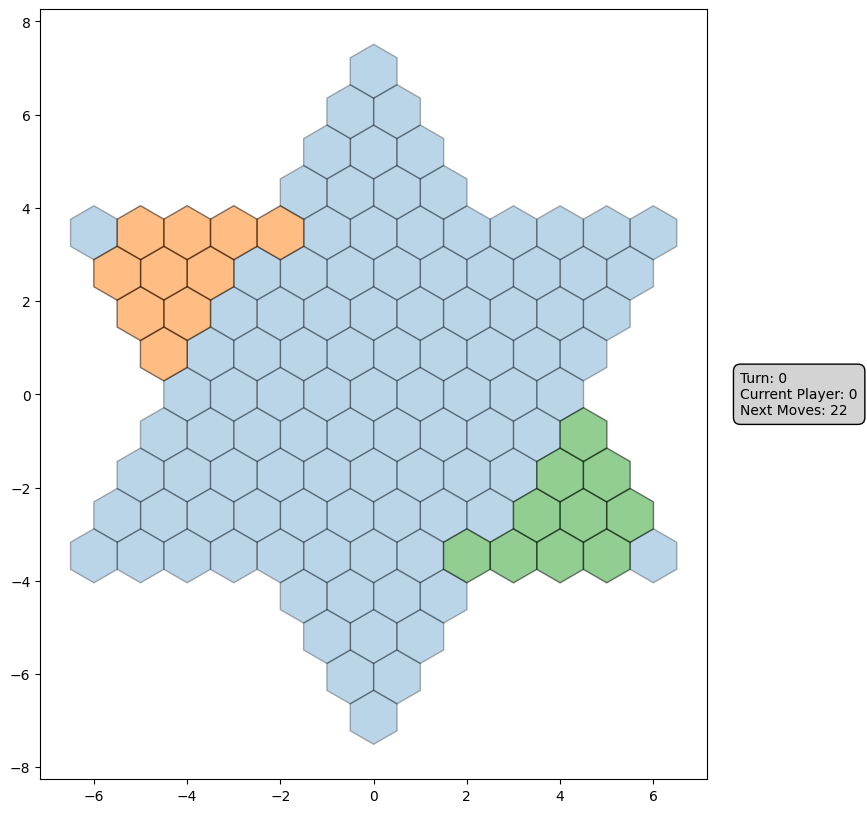

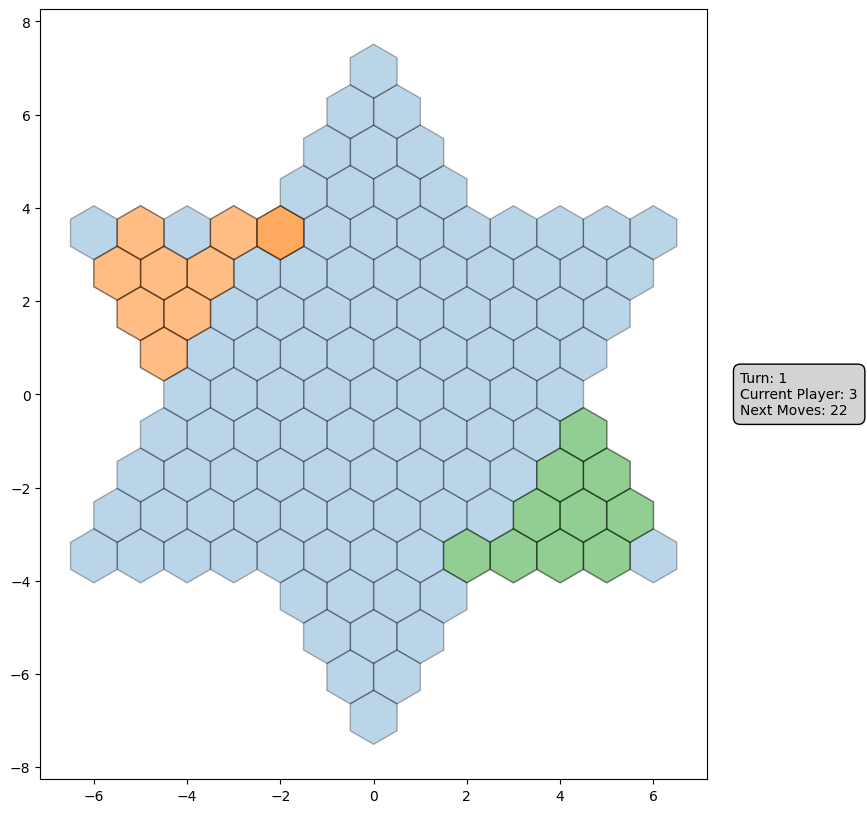

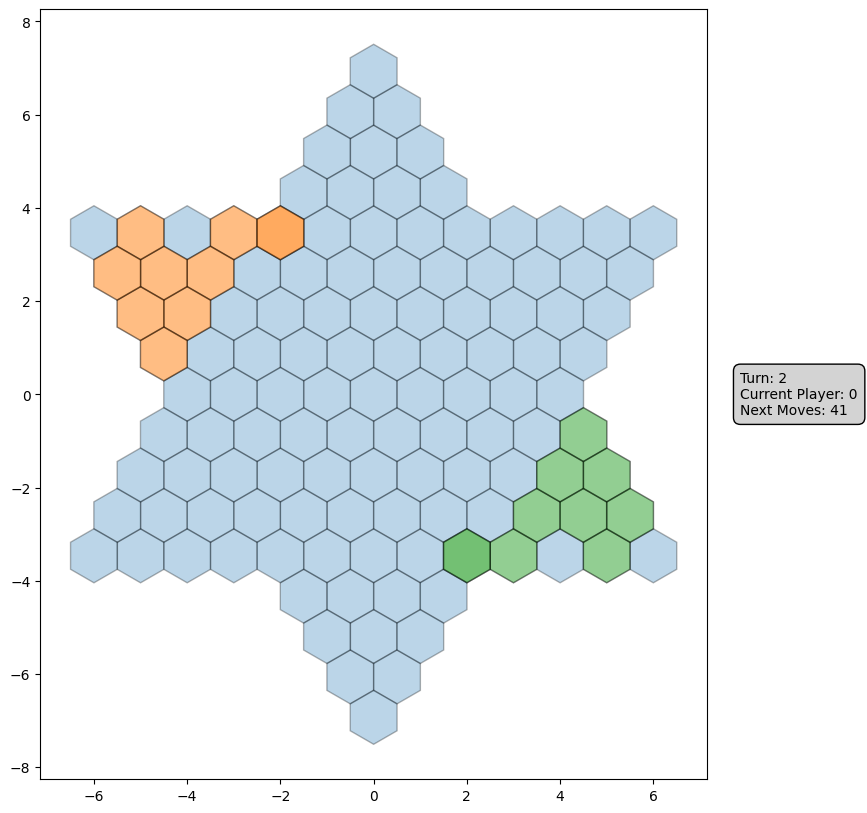

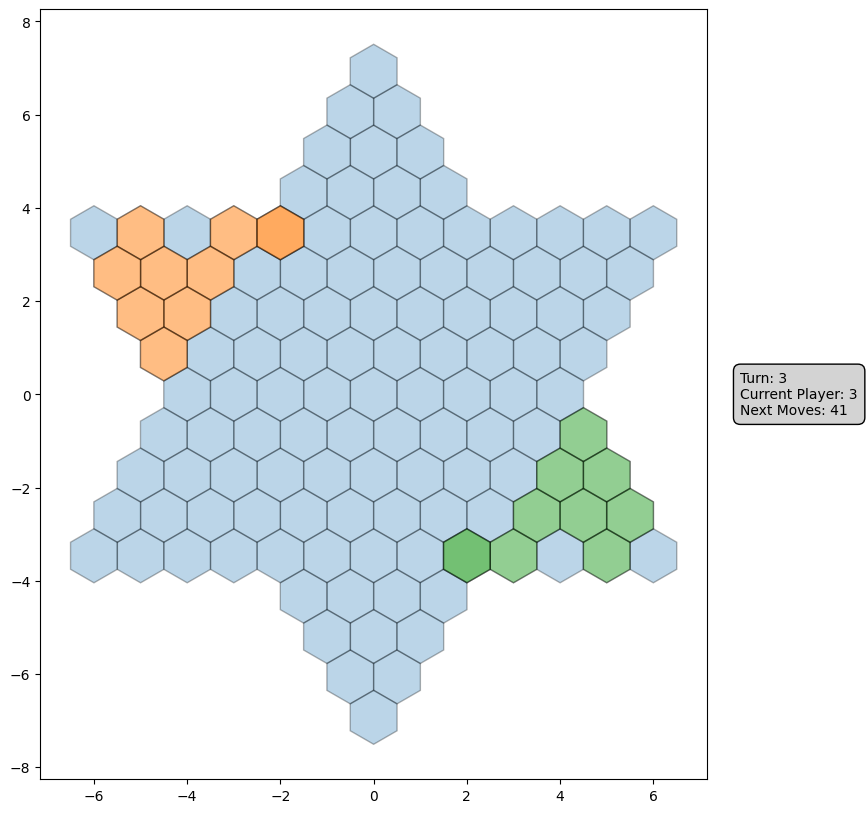

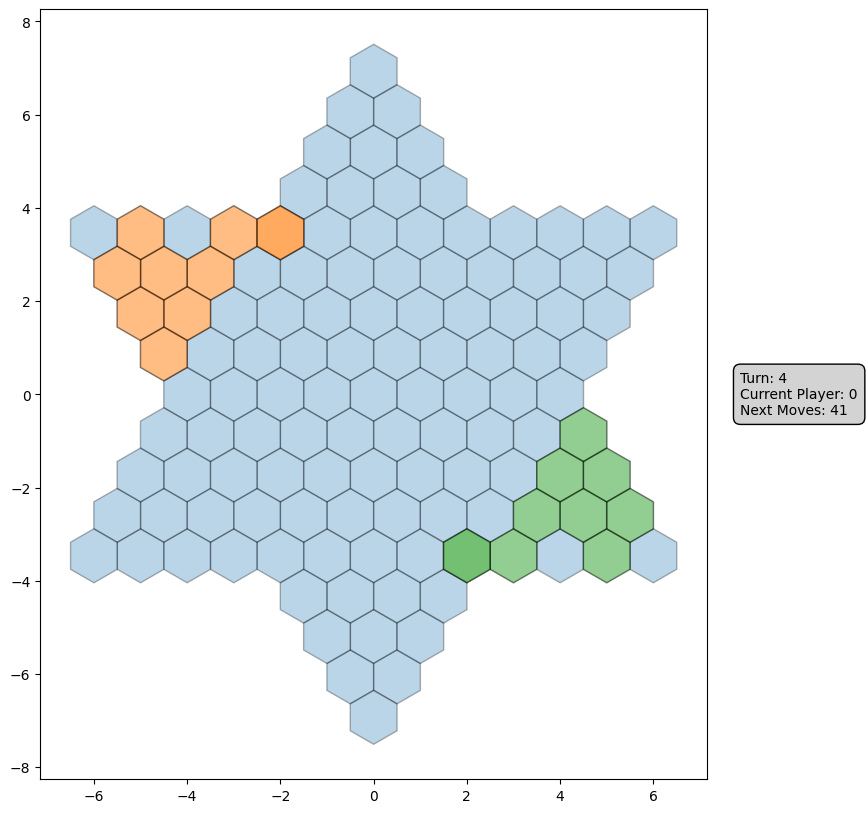

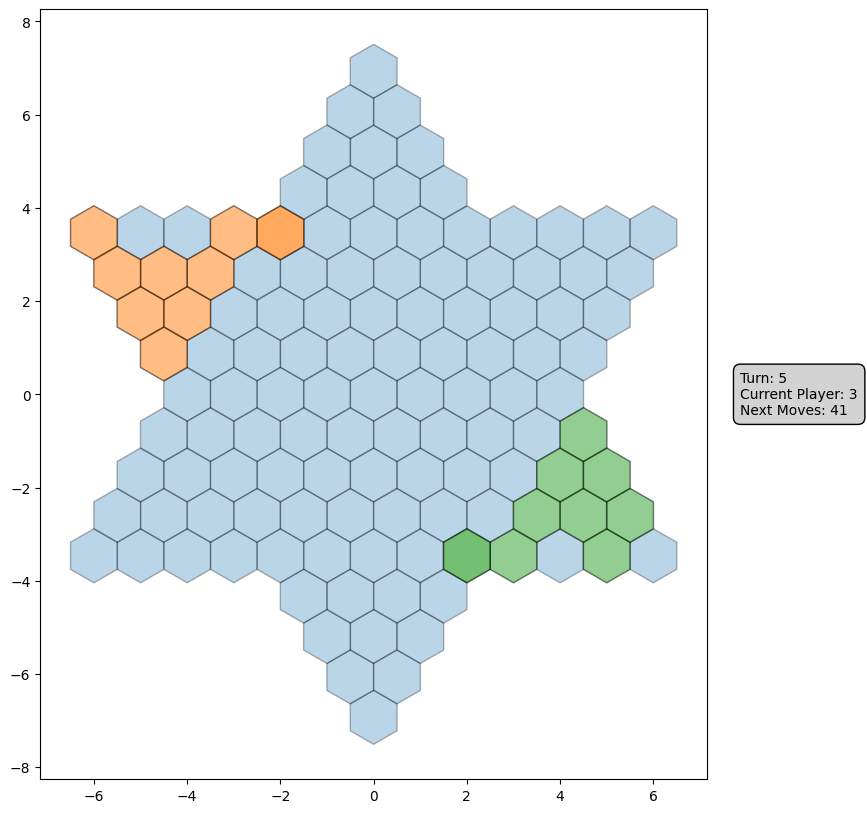

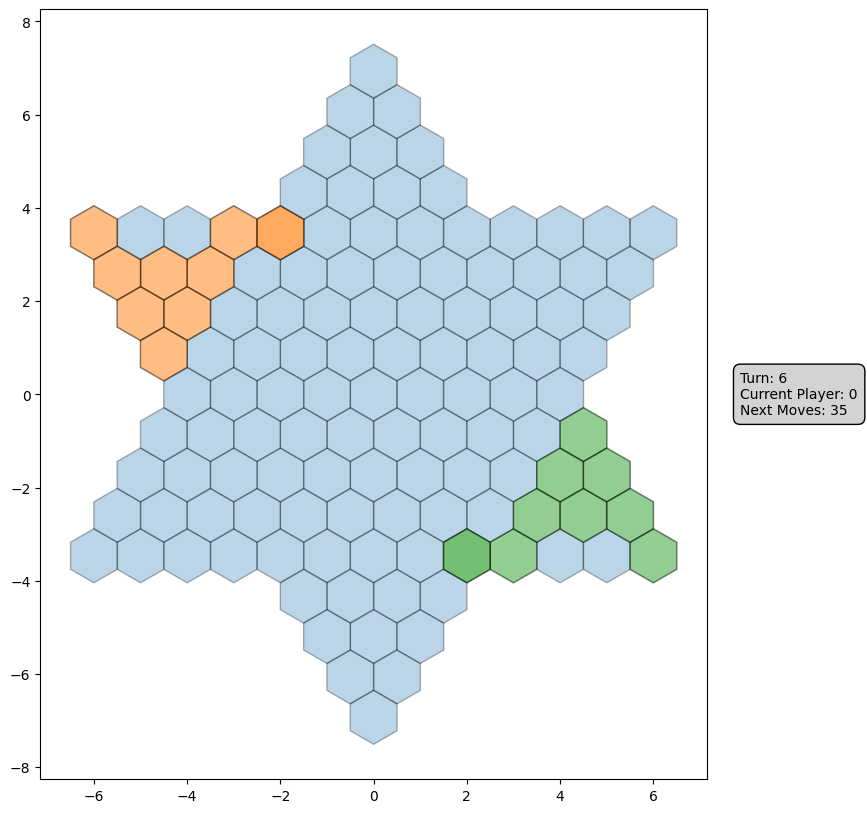

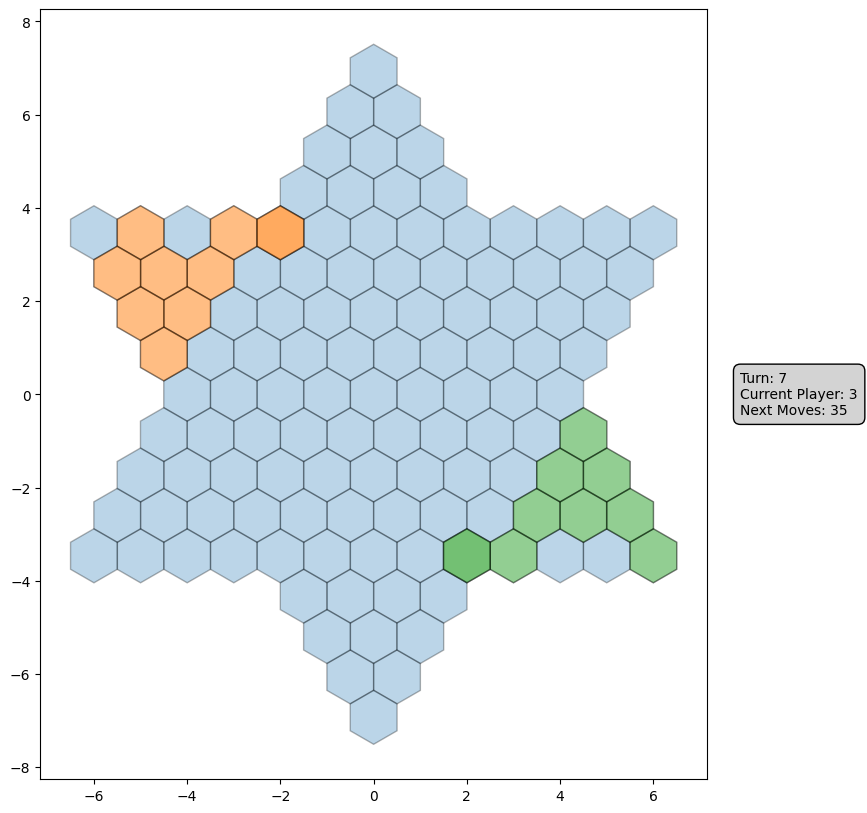

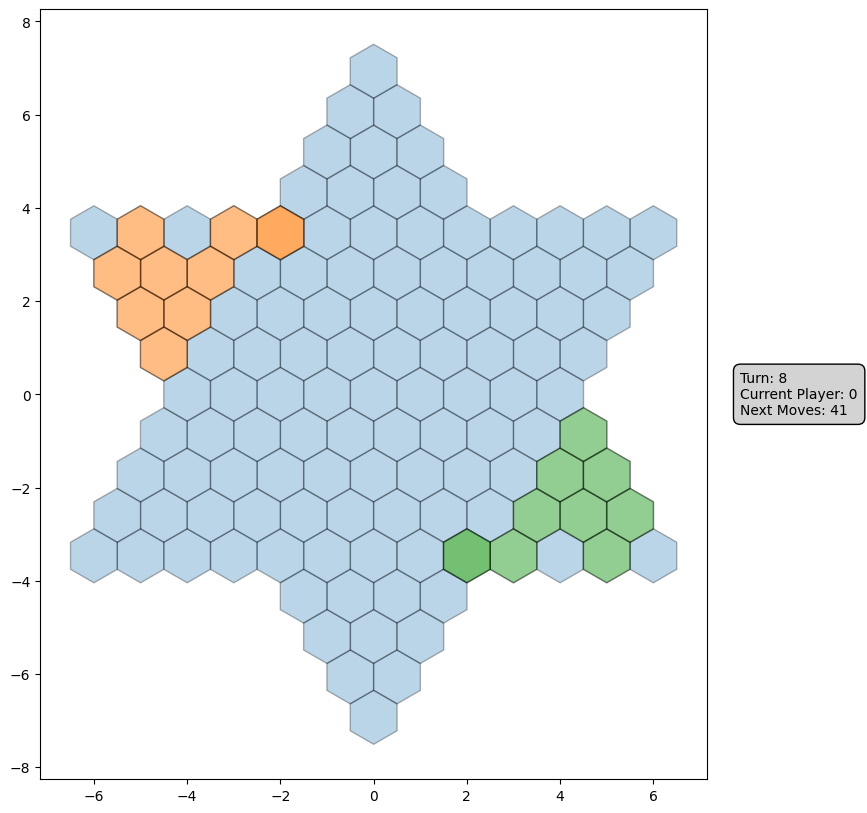

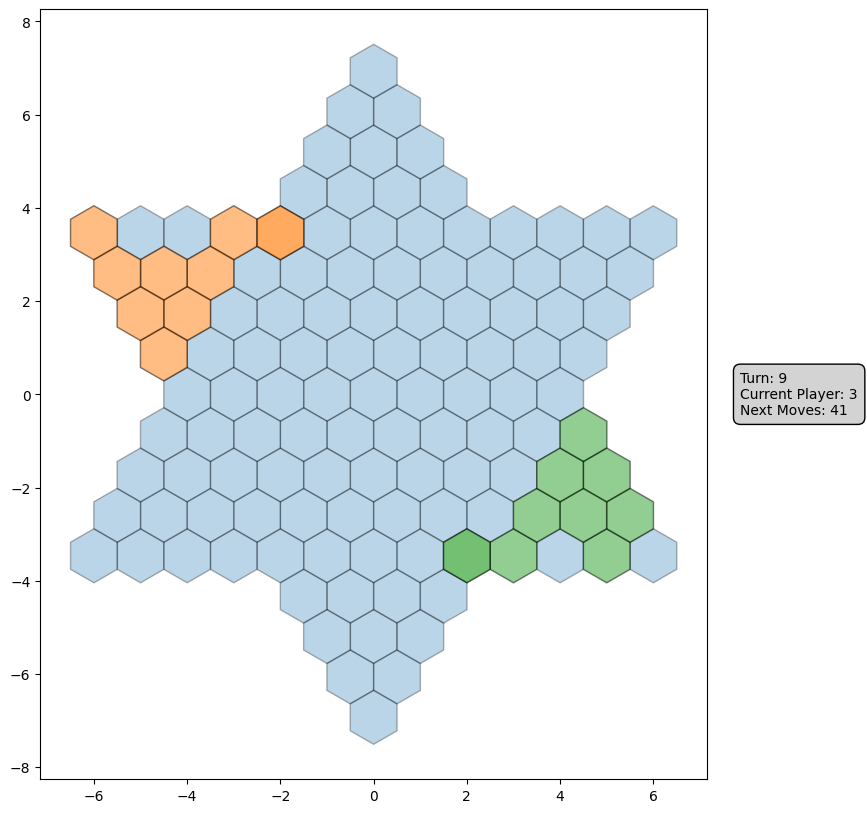

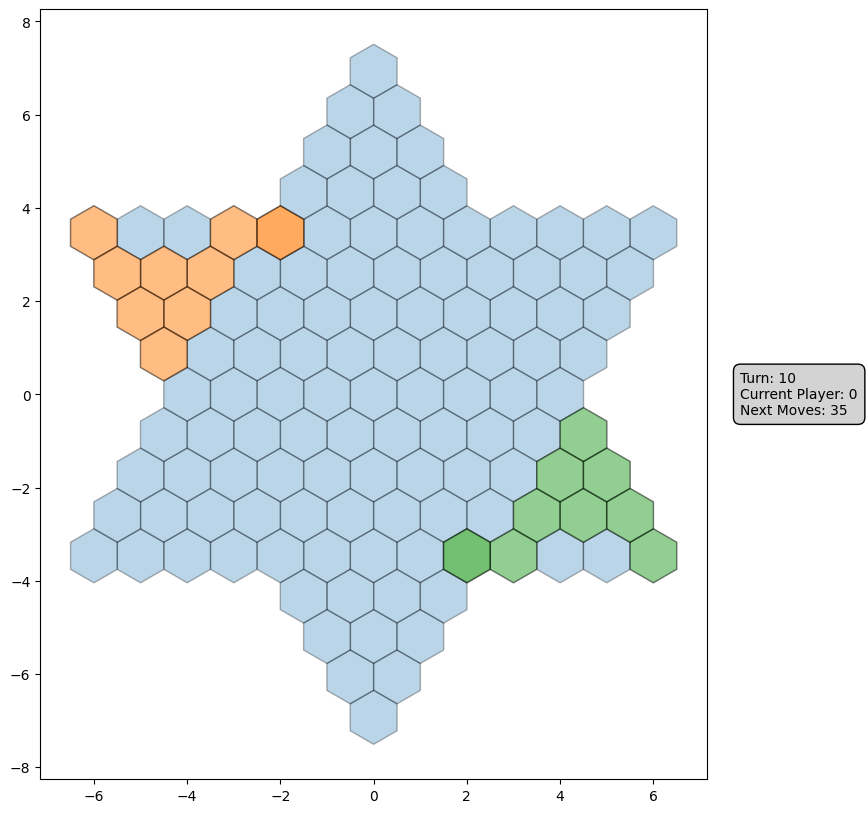

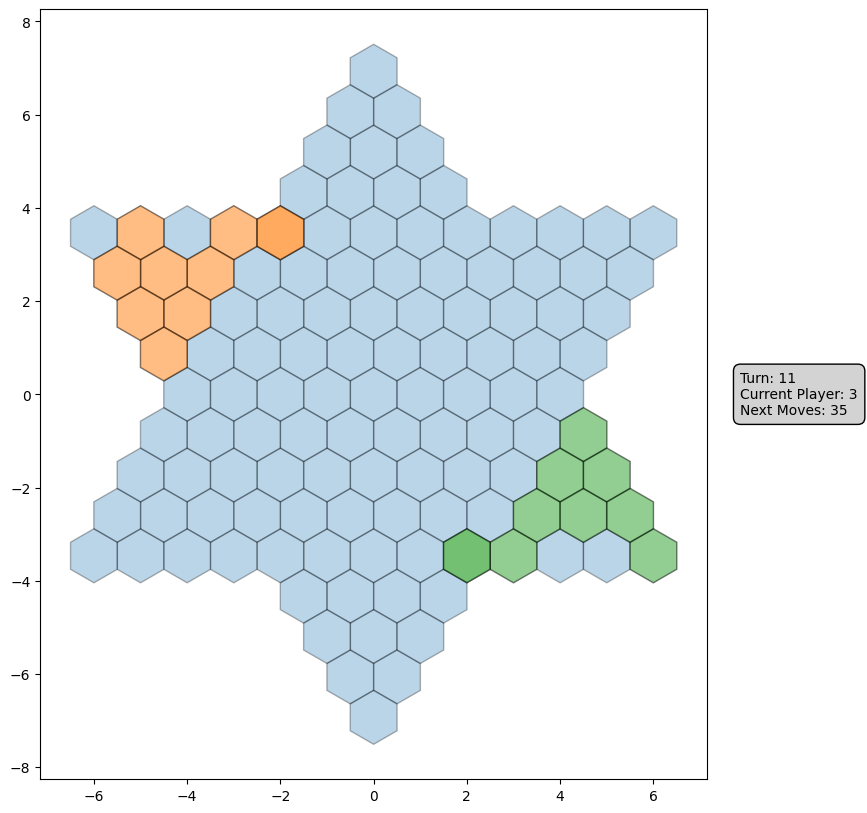

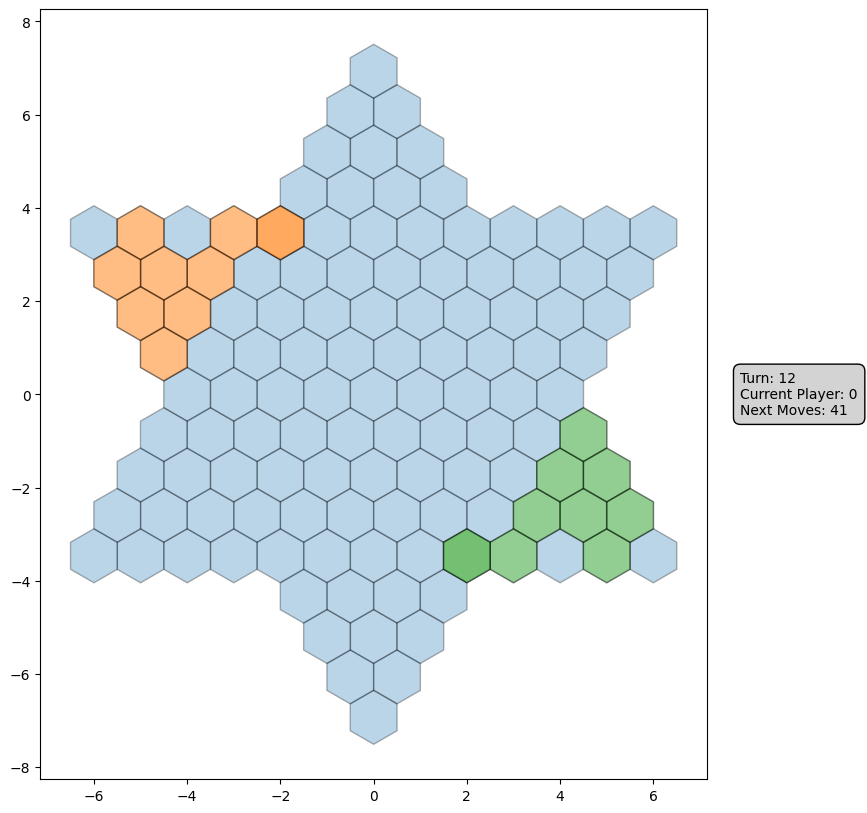

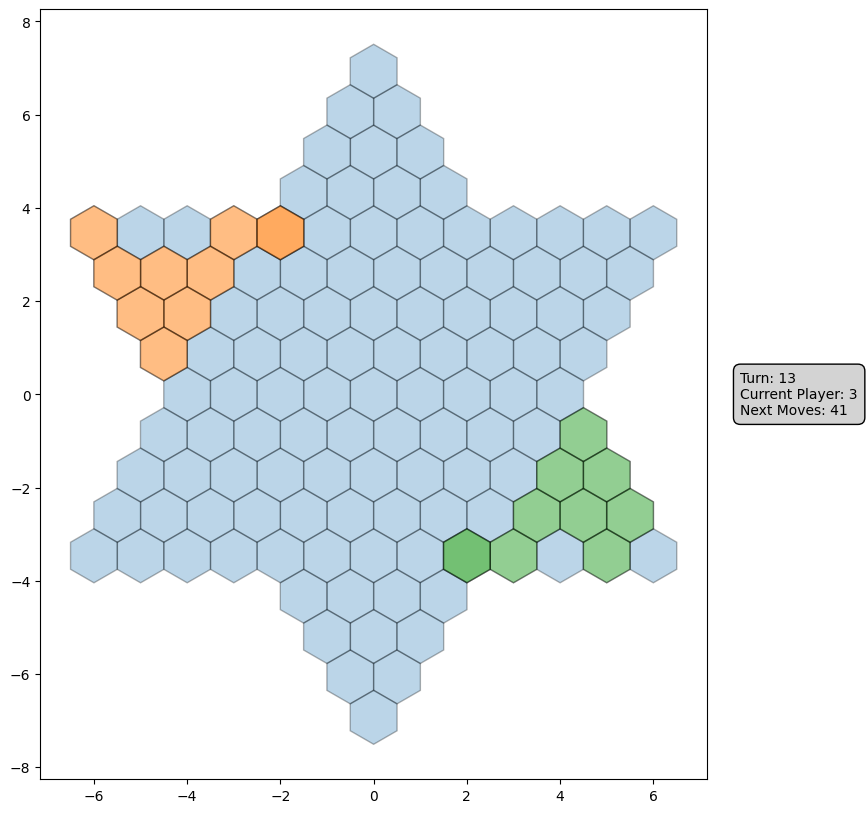

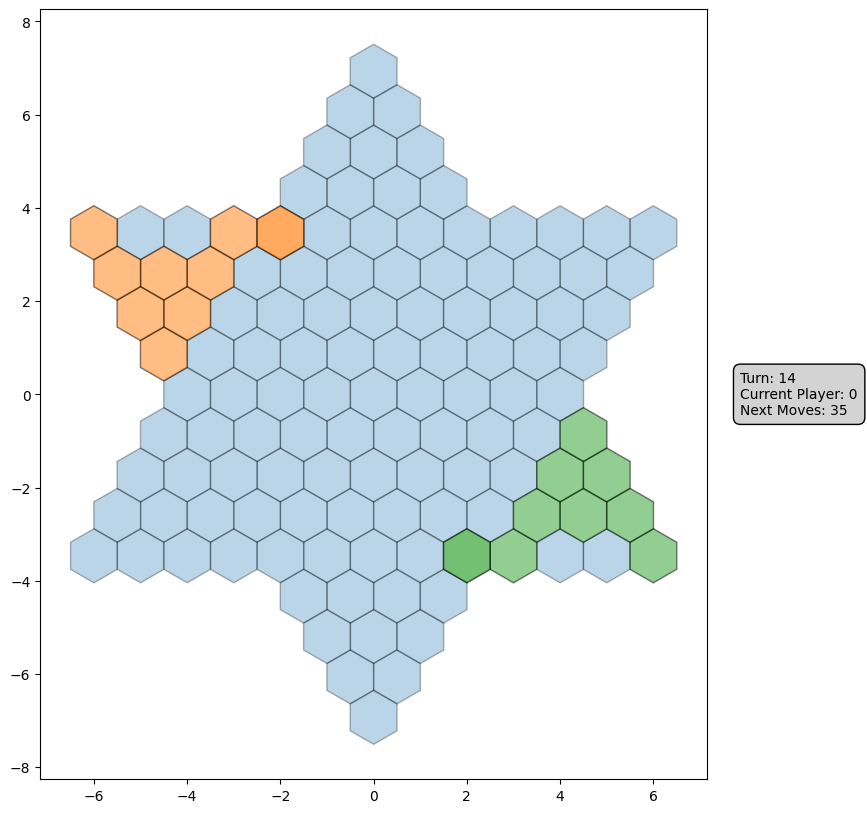

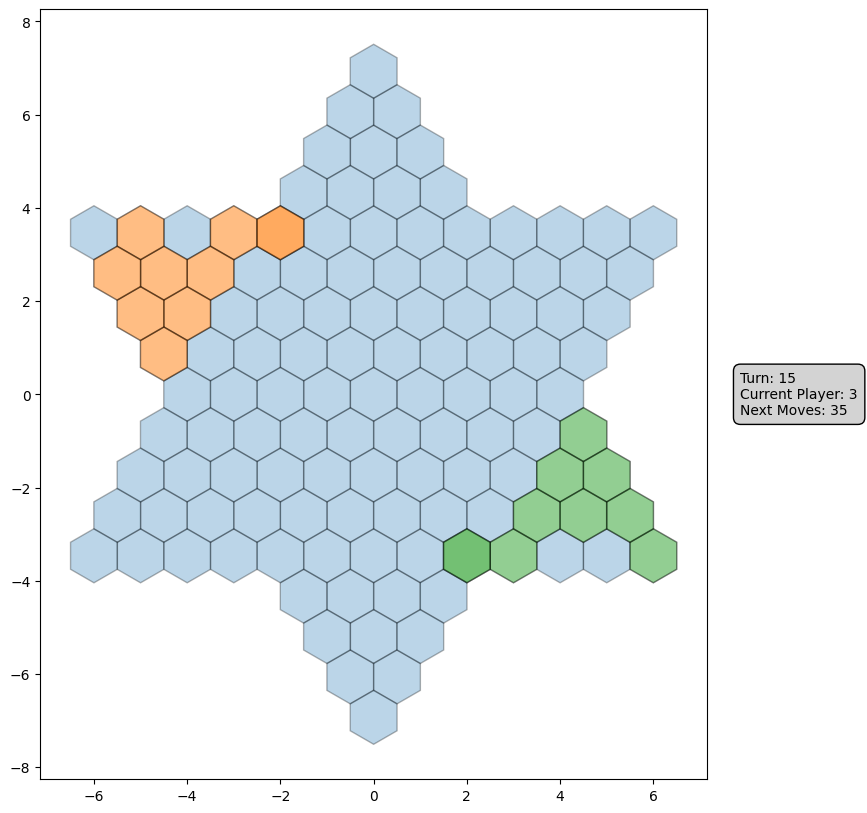

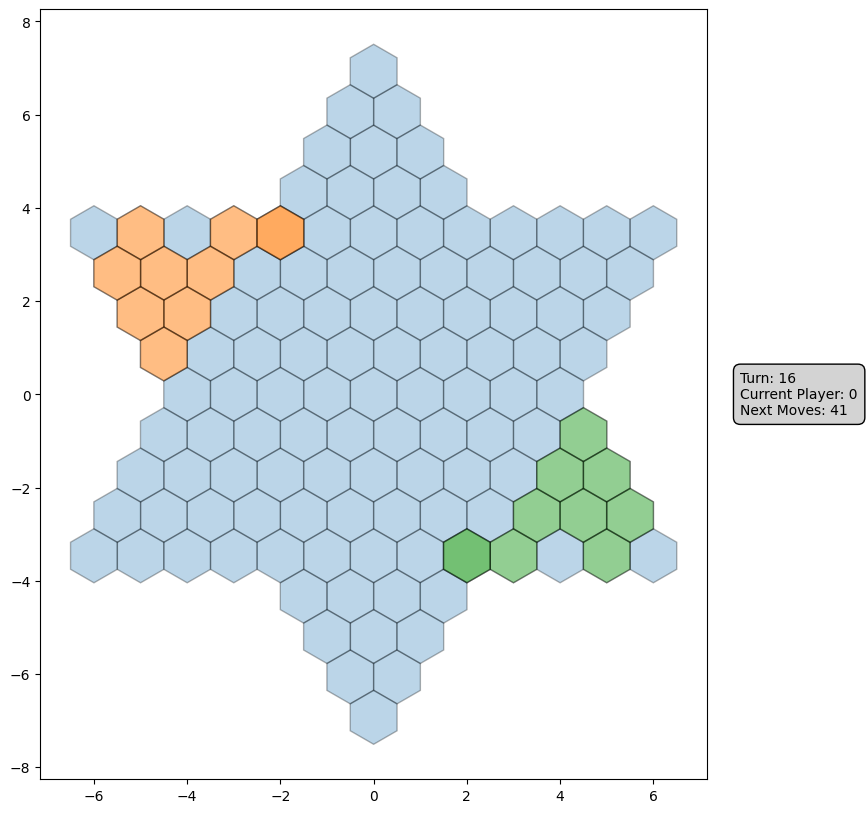

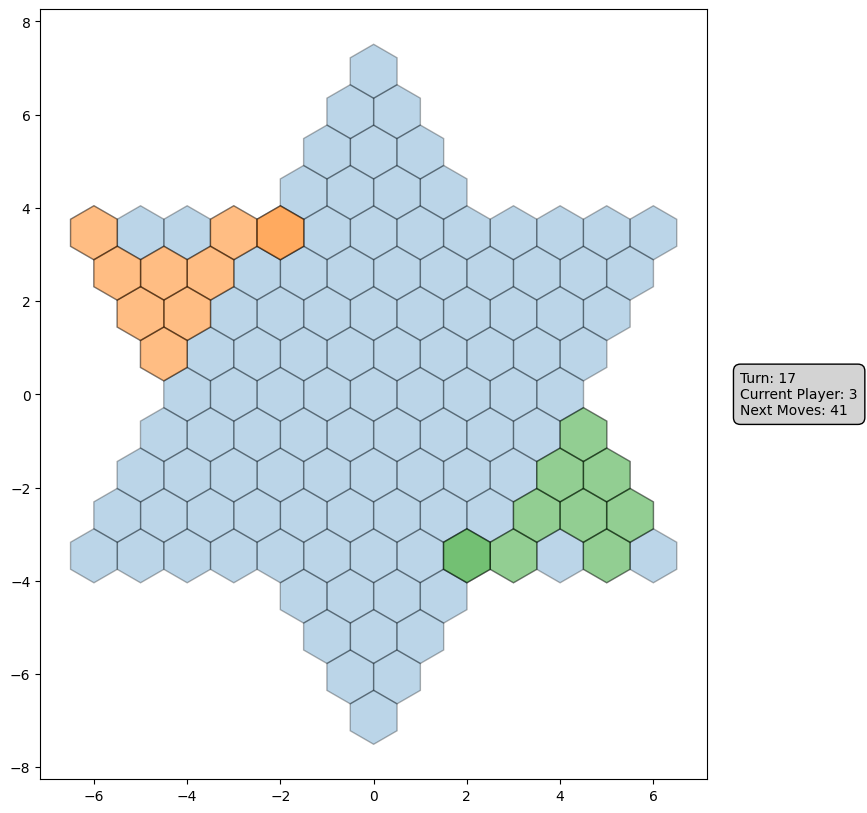

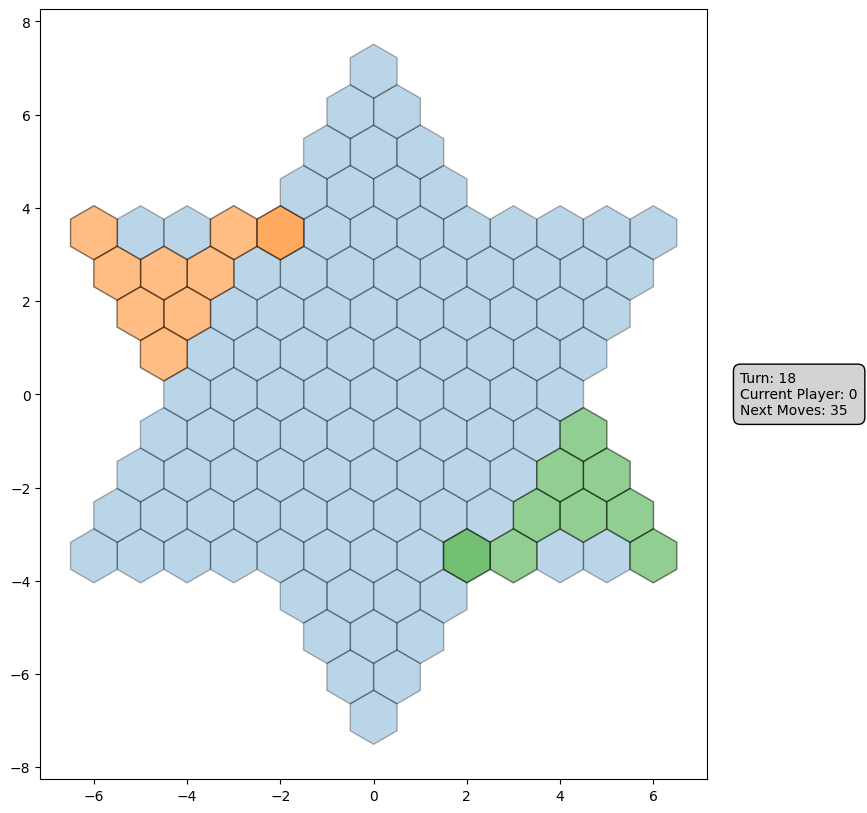

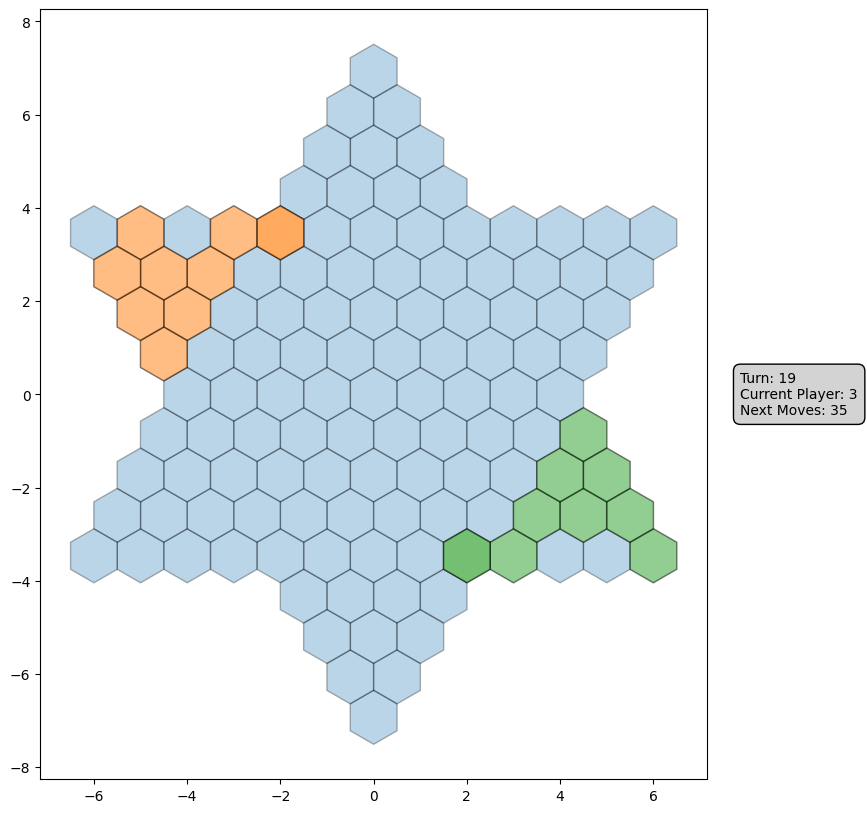

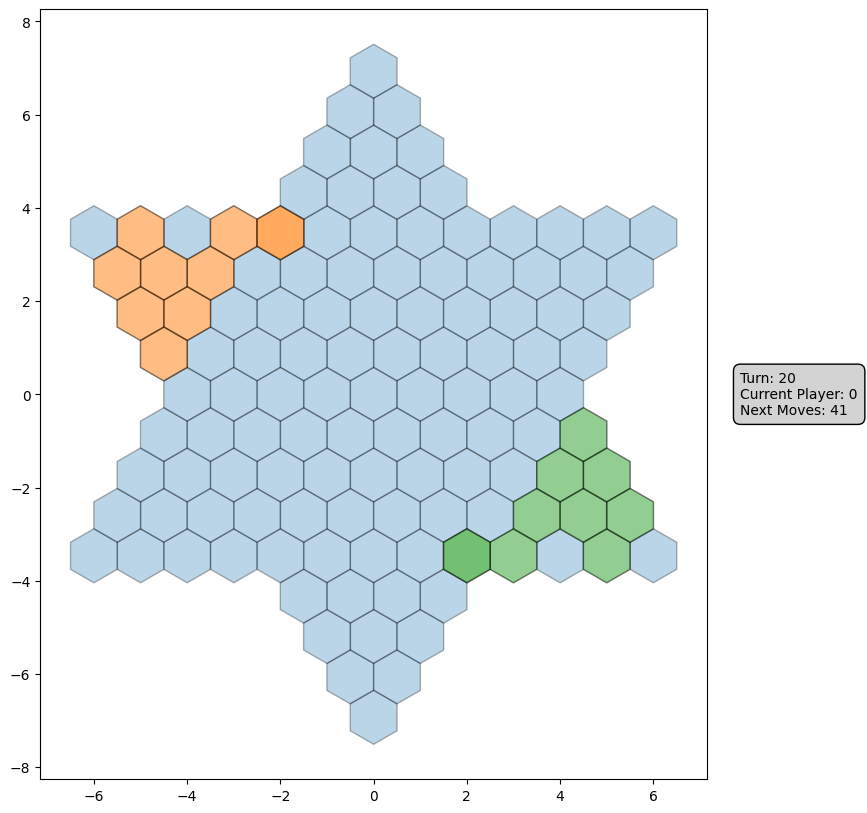

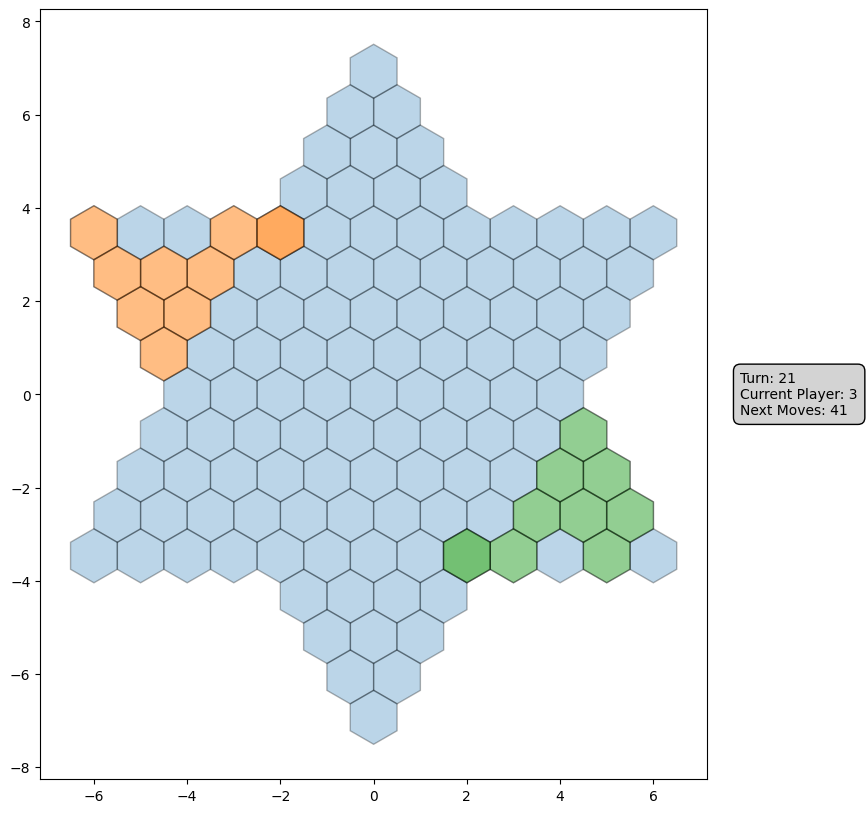

In [24]:
game_sequence = game_simulation._to_game_sequence()
for i, (move, game) in enumerate(zip(game_simulation.data.historical_moves, game_sequence)):
    print(f"\nCurrent Player: {game.get_current_player().player_id} \n{move}\nTurn: {i}")
    game.print()
    if i > 20:
        break